In [1]:
from configparser import ConfigParser
import glob, os, cv2
from pandas import StringDtype
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from pickletools import optimize
import string
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD,RMSprop
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import time
# from draw_ellipse import *
# from ellipses import *
# from bwperim import *
os.environ["CUDA_VISIBLE_DEVICES"]='2,3'
mirrored_strategy = tf.distribute.MirroredStrategy()

# BASE_PATH = "C:/kwoncy/eye/temp_xml/pair/data_sets/eye2"
BASE_PATH_NONBLINK = "./new_data_sets/eye_nonblink"
BASE_PATH_BLINK = "./new_data_sets/eye_blink"
img_height = 240
img_width = 320
FX = 2
FY = 2
SEED = 555

time_start = time.time()

blink_lt_original_paths = sorted(glob.glob(BASE_PATH_BLINK + '/Lt.original/*.png'))
n_blink_lt_imgs = len(blink_lt_original_paths)
print("number of blink_lt_imgs : ", n_blink_lt_imgs)
imgs_lt_original_blink = np.stack([ cv2.imread(f'{BASE_PATH_BLINK}/Lt.original/{i}.png',0) for i in range(n_blink_lt_imgs)])
imgs_lt_original_blink = imgs_lt_original_blink.astype('float32') / 255.

masks_lt_pupil_blink = np.stack([ cv2.imread(f'{BASE_PATH_BLINK}/Lt.pupil/{i}.png',0) for i in range(n_blink_lt_imgs)])
masks_lt_pupil_blink = masks_lt_pupil_blink.astype('float32') / 255.

imgs_train1, imgs_val1, masks_train1, masks_val1 = train_test_split(imgs_lt_original_blink,masks_lt_pupil_blink,test_size=0.2, shuffle=True, random_state=SEED)
print("train_val 1 shape :", imgs_train1.shape, imgs_val1.shape, masks_train1.shape, masks_val1.shape)


blink_rt_original_paths = sorted(glob.glob(BASE_PATH_BLINK + '/Rt.original/*.png'))
n_blink_rt_imgs = len(blink_rt_original_paths)
print("number of blink_rt_imgs : ", n_blink_rt_imgs)
imgs_rt_original_blink = np.stack([ cv2.imread(f'{BASE_PATH_BLINK}/Rt.original/{i}.png',0) for i in range(n_blink_rt_imgs)])
imgs_rt_original_blink = imgs_rt_original_blink.astype('float32') / 255.

masks_rt_pupil_blink = np.stack([ cv2.imread(f'{BASE_PATH_BLINK}/Rt.pupil/{i}.png',0) for i in range(n_blink_rt_imgs)])
masks_rt_pupil_blink = masks_rt_pupil_blink.astype('float32') / 255.

imgs_train2, imgs_val2, masks_train2, masks_val2 = train_test_split(imgs_rt_original_blink,masks_rt_pupil_blink,test_size=0.2, shuffle=True, random_state=SEED)
print("train_val 2 shape :", imgs_train2.shape, imgs_val2.shape, masks_train2.shape, masks_val2.shape)


non_blink_lt_original_paths = sorted(glob.glob(BASE_PATH_NONBLINK + '/Lt.original/*.png'))
n_non_blink_lt_imgs = len(non_blink_lt_original_paths)

l_rand_lt_index = np.random.RandomState(seed = SEED).choice(n_non_blink_lt_imgs, n_blink_lt_imgs, replace=False)
print("number of non_blink_lt_imgs : ", len(l_rand_lt_index))

imgs_lt_original_non_blink = np.stack([ cv2.imread(f'{BASE_PATH_NONBLINK}/Lt.original/{i}.png',0) for i in l_rand_lt_index])
imgs_lt_original_non_blink = imgs_lt_original_non_blink.astype('float32') / 255.

masks_lt_pupil_non_blink = np.stack([ cv2.imread(f'{BASE_PATH_NONBLINK}/Lt.pupil/{i}.png',0) for i in l_rand_lt_index])
masks_lt_pupil_non_blink = masks_lt_pupil_non_blink.astype('float32') / 255.

imgs_train3, imgs_val3, masks_train3, masks_val3 = train_test_split(imgs_lt_original_non_blink,masks_lt_pupil_non_blink,test_size=0.2, shuffle=True, random_state=SEED)
print("train_val 3 shape :", imgs_train3.shape, imgs_val3.shape, masks_train3.shape, masks_val3.shape)


non_blink_rt_original_paths = sorted(glob.glob(BASE_PATH_NONBLINK + '/Rt.original/*.png'))
n_non_blink_rt_imgs = len(non_blink_rt_original_paths)

l_rand_rt_index = np.random.RandomState(seed = SEED).choice(n_non_blink_rt_imgs, n_blink_rt_imgs, replace=False)
print("number of non_blink_rt_imgs : ", len(l_rand_rt_index))

imgs_rt_original_non_blink = np.stack([ cv2.imread(f'{BASE_PATH_NONBLINK}/Rt.original/{i}.png',0) for i in l_rand_rt_index])
imgs_rt_original_non_blink = imgs_rt_original_non_blink.astype('float32') / 255.

masks_rt_pupil_non_blink = np.stack([ cv2.imread(f'{BASE_PATH_NONBLINK}/Rt.pupil/{i}.png',0) for i in l_rand_rt_index])
masks_rt_pupil_non_blink = masks_rt_pupil_non_blink.astype('float32') / 255.


imgs_train4, imgs_val4, masks_train4, masks_val4 = train_test_split(imgs_rt_original_non_blink,masks_rt_pupil_non_blink,test_size=0.2, shuffle=True, random_state=SEED)
print("train_val 4 shaep :", imgs_train4.shape, imgs_val4.shape, masks_train4.shape, masks_val4.shape)


imgs_train_whole = np.concatenate([imgs_train1, imgs_train2, imgs_train3, imgs_train4], axis=0)
imgs_val_whole = np.concatenate([imgs_val1, imgs_val2, imgs_val3, imgs_val4], axis=0)
masks_train_whole = np.concatenate([masks_train1, masks_train2, masks_train3, masks_train4], axis=0)
masks_val_whole = np.concatenate([masks_val1, masks_val2, masks_val3, masks_val4], axis=0)

# imgs_train_whole = np.concatenate([imgs_train3, imgs_train4], axis=0)
# imgs_val_whole = np.concatenate([imgs_val3, imgs_val4], axis=0)
# masks_train_whole = np.concatenate([masks_train3, masks_train4], axis=0)
# masks_val_whole = np.concatenate([masks_val3, masks_val4], axis=0)



print("total of train_val :", imgs_train_whole.shape, imgs_val_whole.shape, masks_train_whole.shape, masks_val_whole.shape)
time_end = time.time()
print("loading times :", time_end - time_start)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
number of blink_lt_imgs :  1181
train_val 1 shape : (944, 240, 320) (237, 240, 320) (944, 240, 320) (237, 240, 320)
number of blink_rt_imgs :  1223
train_val 2 shape : (978, 240, 320) (245, 240, 320) (978, 240, 320) (245, 240, 320)
number of non_blink_lt_imgs :  1181
train_val 3 shape : (944, 240, 320) (237, 240, 320) (944, 240, 320) (237, 240, 320)
number of non_blink_rt_imgs :  1223
train_val 4 shaep : (978, 240, 320) (245, 240, 320) (978, 240, 320) (245, 240, 320)
total of train_val : (3844, 240, 320) (964, 240, 320) (3844, 240, 320) (964, 240, 320)
loading times : 371.8530251979828


In [2]:
time_start = time.time()

imgs_train_flip1 = imgs_train_whole[:,:,-1::-1].copy()
imgs_val_flip1 = imgs_val_whole[:,:,-1::-1].copy()
masks_train_flip1 = masks_train_whole[:,:,-1::-1].copy()
masks_val_flip1 = masks_val_whole[:,:,-1::-1].copy()

imgs_train_concat1 = np.concatenate([imgs_train_whole, imgs_train_flip1], axis=0)
imgs_val_concat1 = np.concatenate([imgs_val_whole, imgs_val_flip1], axis=0)
masks_train_concat1 = np.concatenate([masks_train_whole, masks_train_flip1], axis=0)
masks_val_concat1 = np.concatenate([masks_val_whole, masks_val_flip1], axis=0)

print("train_val_flip1 : ", imgs_train_concat1.shape, imgs_val_concat1.shape, masks_train_concat1.shape, masks_val_concat1.shape)

# imgs_train_flip2 = imgs_train_concat1[:,-1::-1,:].copy()
# imgs_val_flip2 = imgs_val_concat1[:,-1::-1,:].copy()
# masks_train_flip2 = masks_train_concat1[:,-1::-1,:].copy()
# masks_val_flip2 = masks_val_concat1[:,-1::-1,:].copy()

# imgs_train_concat2 = np.concatenate([imgs_train_concat1, imgs_train_flip2], axis=0)
# imgs_val_concat2 = np.concatenate([imgs_val_concat1, imgs_val_flip2], axis=0)
# masks_train_concat2 = np.concatenate([masks_train_concat1, masks_train_flip2], axis=0)
# masks_val_concat2 = np.concatenate([masks_val_concat1, masks_val_flip2], axis=0)

# print("train_val_flip2 : ", imgs_train_concat2.shape, imgs_val_concat2.shape, masks_train_concat2.shape, masks_val_concat2.shape)

imgs_train = imgs_train_concat1
imgs_val = imgs_val_concat1
masks_train = masks_train_concat1
masks_val = masks_val_concat1

time_end = time.time()
print("loading times :", time_end - time_start)

train_val_flip1 :  (7688, 240, 320) (1928, 240, 320) (7688, 240, 320) (1928, 240, 320)
loading times : 2.3410747051239014


In [3]:
def build_AE3(img_height=240,img_width=320,filters=32,activation='elu',kernel_init='he_uniform'):
    FILTERS = filters
    ACTIVATION_FN = activation
    KERNEL_INIT = kernel_init

    ###### encoder
    layer1 = Input(shape = (img_height,img_width,1))
    layer2 = Conv2D(filters = FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer1)
    layer3 = BatchNormalization()(layer2)
    layer4 = Activation(ACTIVATION_FN)(layer3)
    layer5 = MaxPool2D(strides=(2,2))(layer4)
    
    layer6 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer5)
    layer7 = BatchNormalization()(layer6)
    layer8 = Activation(ACTIVATION_FN)(layer7)
    layer9 = MaxPool2D(strides=(2,2))(layer8)
    
    layer10 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer9)
    layer11 = BatchNormalization()(layer10)
    layer12 = Activation(ACTIVATION_FN)(layer11)
    layer13 = MaxPool2D(strides=(2,2))(layer12)
    
    layer14 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer13)
    layer15 = BatchNormalization()(layer14)
    layer16 = Activation(ACTIVATION_FN)(layer15)
    layer17 = UpSampling2D(size=(2,2))(layer16)
    
    layer18 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer17)
    layer19 = BatchNormalization()(layer18)
    layer20 = Activation(ACTIVATION_FN)(layer19)
    layer21 = UpSampling2D(size=(2,2))(layer20)
    
    layer22 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer21)
    layer23 = BatchNormalization()(layer22)
    layer24 = Activation(ACTIVATION_FN)(layer23)
    layer25 = UpSampling2D(size=(2,2))(layer24)
    
    layer26 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer25)
    layer27 = BatchNormalization()(layer26)
    layer28 = Activation(ACTIVATION_FN)(layer27)
    
    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid', kernel_initializer=KERNEL_INIT, padding='same')(layer28)
    
    return Model(layer1, output_layer)
    
    
#     layer5 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer4)
#     layer6 = BatchNormalization()(layer5)
#     layer7 = Activation(ACTIVATION_FN)(layer6)
#     layer8 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer7)
#     layer9 = BatchNormalization()(layer8)
# #     layer10 = Add()([layer4,layer9])
#     layer11 = Activation(ACTIVATION_FN)(layer9)

#     layer12 = MaxPool2D(strides=(2,2))(layer11)

#     layer13 = Conv2D(filters=FILTERS *2, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer12)
#     layer14 = BatchNormalization()(layer13)
#     layer15 = Activation(ACTIVATION_FN)(layer14)
#     layer16 = Conv2D(filters=FILTERS *2, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer15)
#     layer17 = BatchNormalization()(layer16)
# #     layer18 = Add()([layer17,layer13])
#     layer19 = Activation(ACTIVATION_FN)(layer17)

#     layer20 = MaxPool2D(strides=(2,2))(layer19)

#     layer21 = Conv2D(filters=FILTERS *4, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer20)
#     layer22 = BatchNormalization()(layer21)
#     layer23 = Activation(ACTIVATION_FN)(layer22)
#     layer24 = Conv2D(filters=FILTERS *4, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer23)
#     layer25 = BatchNormalization()(layer24)
# #     layer26 = Add()([layer25,layer21])
#     layer27 = Activation(ACTIVATION_FN)(layer25)

#     layer28 = MaxPool2D(strides=(2,2))(layer27)

#     layer29 = Conv2D(filters=FILTERS *8, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer28)
#     layer30 = BatchNormalization()(layer29)
#     layer31 = Activation(ACTIVATION_FN)(layer30) 
#     layer32 = Conv2D(filters=FILTERS *8, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer31)
#     layer33 = BatchNormalization()(layer32)
# #     layer34 = Add()([layer33,layer29])
#     layer35 = Activation(ACTIVATION_FN)(layer33)
    

#     #### decoder
#     layer36 = UpSampling2D(size=(2,2))(layer35)
    
#     layer37 = Conv2D(filters=FILTERS *4, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer36)
#     layer38 = BatchNormalization()(layer37)
#     layer39 = Activation(ACTIVATION_FN)(layer38)
#     layer40 = Conv2D(filters=FILTERS *4, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer39)
#     layer41 = BatchNormalization()(layer40)
# #     layer42 = Add()([layer37,layer41])
#     layer43 = Activation(ACTIVATION_FN)(layer41)

#     layer44 = UpSampling2D(size=(2,2))(layer43)

#     layer45 = Conv2D(filters=FILTERS *2, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer44)
#     layer46 = BatchNormalization()(layer45)
#     layer47 = Activation(ACTIVATION_FN)(layer46)
#     layer48 = Conv2D(filters=FILTERS *2, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer47)
#     layer49 = BatchNormalization()(layer48)
# #     layer50 = Add()([layer49,layer45])
#     layer51 = Activation(ACTIVATION_FN)(layer49)

#     layer52 = UpSampling2D(size=(2,2))(layer51)

#     layer53 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer52)
#     layer54 = BatchNormalization()(layer53)
#     layer55 = Activation(ACTIVATION_FN)(layer54)
#     layer56 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer55)
#     layer57 = BatchNormalization()(layer56)
# #     layer58 = Add()([layer57,layer53])
#     layer59 = Activation(ACTIVATION_FN)(layer57)

#     layer60 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer59)
#     layer61 = BatchNormalization()(layer60)
#     layer62 = Activation(ACTIVATION_FN)(layer61)

#     output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid', kernel_initializer=KERNEL_INIT, padding='same')(layer62)
    
#     return Model(layer1, output_layer)






In [4]:
def build_AE(img_height=240,img_width=320,filters=32,activation='elu',kernel_init='he_uniform'):
    FILTERS = filters
    ACTIVATION_FN = activation
    KERNEL_INIT = kernel_init

    ###### encoder
    layer1 = Input(shape = (img_height,img_width,1))
    layer2 = Conv2D(filters = FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer1)
    layer3 = BatchNormalization()(layer2)
    layer4 = Activation(ACTIVATION_FN)(layer3)
    
    layer5 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer4)
    layer6 = BatchNormalization()(layer5)
    layer7 = Activation(ACTIVATION_FN)(layer6)
    layer8 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer7)
    layer9 = BatchNormalization()(layer8)
    layer10 = Add()([layer4,layer9])
    layer11 = Activation(ACTIVATION_FN)(layer10)

    layer12 = MaxPool2D(strides=(2,2))(layer11)

    layer13 = Conv2D(filters=FILTERS *2, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer12)
    layer14 = BatchNormalization()(layer13)
    layer15 = Activation(ACTIVATION_FN)(layer14)
    layer16 = Conv2D(filters=FILTERS *2, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer15)
    layer17 = BatchNormalization()(layer16)
    layer18 = Add()([layer17,layer13])
    layer19 = Activation(ACTIVATION_FN)(layer18)

    layer20 = MaxPool2D(strides=(2,2))(layer19)

    layer21 = Conv2D(filters=FILTERS *4, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer20)
    layer22 = BatchNormalization()(layer21)
    layer23 = Activation(ACTIVATION_FN)(layer22)
    layer24 = Conv2D(filters=FILTERS *4, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer23)
    layer25 = BatchNormalization()(layer24)
    layer26 = Add()([layer25,layer21])
    layer27 = Activation(ACTIVATION_FN)(layer26)

    layer28 = MaxPool2D(strides=(2,2))(layer27)

    layer29 = Conv2D(filters=FILTERS *8, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer28)
    layer30 = BatchNormalization()(layer29)
    layer31 = Activation(ACTIVATION_FN)(layer30) 
    layer32 = Conv2D(filters=FILTERS *8, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer31)
    layer33 = BatchNormalization()(layer32)
    layer34 = Add()([layer33,layer29])
    layer35 = Activation(ACTIVATION_FN)(layer34)
    

    #### decoder
    layer36 = UpSampling2D(size=(2,2))(layer35)
    
    layer37 = Conv2D(filters=FILTERS *4, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer36)
    layer38 = BatchNormalization()(layer37)
    layer39 = Activation(ACTIVATION_FN)(layer38)
    layer40 = Conv2D(filters=FILTERS *4, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer39)
    layer41 = BatchNormalization()(layer40)
    layer42 = Add()([layer37,layer41])
    layer43 = Activation(ACTIVATION_FN)(layer42)

    layer44 = UpSampling2D(size=(2,2))(layer43)

    layer45 = Conv2D(filters=FILTERS *2, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer44)
    layer46 = BatchNormalization()(layer45)
    layer47 = Activation(ACTIVATION_FN)(layer46)
    layer48 = Conv2D(filters=FILTERS *2, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer47)
    layer49 = BatchNormalization()(layer48)
    layer50 = Add()([layer49,layer45])
    layer51 = Activation(ACTIVATION_FN)(layer50)

    layer52 = UpSampling2D(size=(2,2))(layer51)

    layer53 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer52)
    layer54 = BatchNormalization()(layer53)
    layer55 = Activation(ACTIVATION_FN)(layer54)
    layer56 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer55)
    layer57 = BatchNormalization()(layer56)
    layer58 = Add()([layer57,layer53])
    layer59 = Activation(ACTIVATION_FN)(layer58)

    layer60 = Conv2D(filters=FILTERS, kernel_size=(3,3), activation=None, kernel_initializer=KERNEL_INIT, padding='same')(layer59)
    layer61 = BatchNormalization()(layer60)
    layer62 = Activation(ACTIVATION_FN)(layer61)

    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid', kernel_initializer=KERNEL_INIT, padding='same')(layer61)
    
    return Model(layer1, output_layer)


In [5]:
def dice_score(y_ture, y_pred):
    y_true_f = K.flatten(y_ture)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [6]:
# weight_saver = ModelCheckpoint('pupil', monitor='val_dice_score', save_best_only=True, save_weights_only=True)
# decayed_lr = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x)
decayed_lr = LearningRateScheduler(lambda x: 2e-4 * 0.9 ** x)
# decayed_lr = LearningRateScheduler(lambda x: 3e-4 * 0.9 ** x)


fold_no = 1
EPOCHS = 15
BATCH_SIZE = 5
RANDOM_STATE = SEED
dice_per_fold = []
loss_per_fold = []
acc_per_fold = []
# model = pupil2_model().summary()
# from sklearn.model_selection import KFold
# kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# with mirrored_strategy.scope():

# model = build_AE2(img_height=240, img_width=320, filters=32)
model = build_AE(img_height=240, img_width=320, filters=32, activation='elu',kernel_init='he_uniform')
model.summary()
#     model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_score])
model.compile(optimizer=Adam(2e-4), loss='mse', metrics=[dice_score])
# model.compile(optimizer=RMSprop(2e-5), loss='binary_crossentropy', metrics=['Accuracy'])
# model.compile(optimizer=SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov = True), loss='binary_crossentropy', metrics=[dice_score])
# model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=['accuracy'])

    # model.compile(optimizer=Adam(3e-4), loss='binary_crossentropy', metrics=[dice_score])
    # model.compile(optimizer=SGD(2e-4), loss='binary_crossentropy', metrics=[dice_score])

# imgs_train = imgs_train[:,:,:,np.newaxis]
# imgs_val = imgs_val[:,:,:,np.newaxis]

# history = model.fit(imgs_train, imgs_train, validation_data=(imgs_val, imgs_val),batch_size=BATCH_SIZE,epochs=EPOCHS, shuffle=True, verbose=2, callbacks=[decayed_lr])
history = model.fit(imgs_train, imgs_train, validation_data=(imgs_val, imgs_val), batch_size=BATCH_SIZE,epochs=EPOCHS, shuffle=True, verbose=2)
scores = model.evaluate(imgs_val, imgs_val, verbose=2)
dice_per_fold.append(scores[1] * 10000)
print(scores)

# with tf.device("/device:CPU:0"):
# history = model.fit(imgs_train,masks_train,batch_size=5,epochs=50,validation_data=(imgs_val,masks_val), shuffle=True, verbose=2, callbacks=[weight_saver, decayed_lr])
# history = model.fit(imgs_train,masks_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(imgs_val,masks_val), shuffle=True, verbose=2, callbacks=[weight_saver, decayed_lr])

# model.save(f'pupil2_{img_width}x{img_height}_{imgs_lt_original_.shape[0]}_E{EPOCHS}_B{BATCH_SIZE}_R{RANDOM_STATE}_S{round(history.history["val_dice_score"][-1],5)}.h5')
model.save(f'AE3_{img_width}x{img_height}_{imgs_train.shape[0]}_E{EPOCHS}_B{BATCH_SIZE}_R{RANDOM_STATE}_S{round(np.mean(dice_per_fold))}.h5')
# model.save("pupil3.h5")
# model.save(f'pupil2_{img_width}x{img_height}_{imgs_lt_original.shape[0]}_{EPOCHS}_{BATCH_SIZE}.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 320, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 320, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Epoch 1/15
1538/1538 - 78s - loss: 0.0053 - dice_score: 0.8203 - val_loss: 8.4383e-04 - val_dice_score: 0.8307
Epoch 2/15
1538/1538 - 72s - loss: 0.0012 - dice_score: 0.8328 - val_loss: 8.1040e-04 - val_dice_score: 0.8279
Epoch 3/15
1538/1538 - 72s - loss: 9.6683e-04 - dice_score: 0.8345 - val_loss: 6.2636e-04 - val_dice_score: 0.8331
Epoch 4/15
1538/1538 - 72s - loss: 7.3001e-04 - dice_score: 0.8352 - val_loss: 3.8544e-04 - val_dice_score: 0.8385
Epoch 5/15
1538/1538 - 72s - loss: 6.8772e-04 - dice_score: 0.8353 - val_loss: 3.9684e-04 - val_dice_score: 0.8373
Epoch 6/15
1538/1538 - 72s - loss: 5.8823e-04 - dice_score: 0.8357 - val_loss: 9.3221e-04 - val_dice_score: 0.8379
Epoch 7/15
1538/1538 - 72s - loss: 4.9169e-04 - dice_score: 0.8360 - val_loss: 2.5714e-04 - val_dice_score: 0.8371
Epoch 8/15
1538/1538 - 72s - loss: 5.5717e-04 - dice_score: 0.8359 - val_loss: 5.2242e-04 - val_dice_score: 0.8290
Epoch 9/15
1538/1538 - 72s - loss: 5.9290e-04 - dice_score: 0.8359 - val_loss: 0.0371 - 

/home/ubuntu/anaconda3/envs/kwon/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


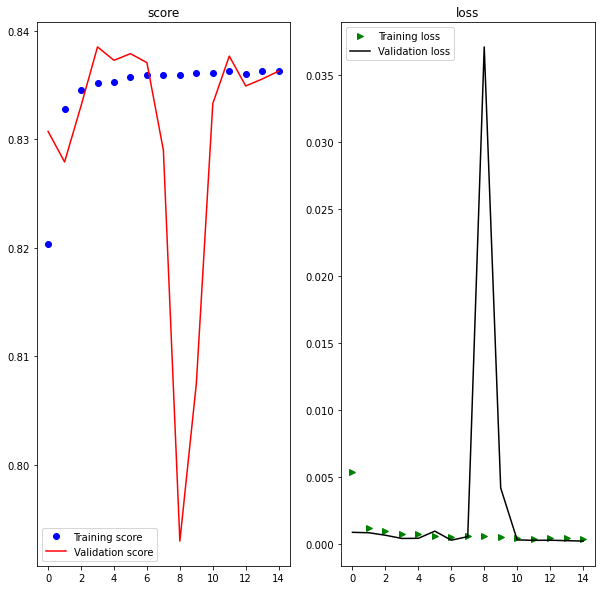

In [9]:
dice_score_ = history.history['dice_score']
val_dice_score = history.history['val_dice_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(dice_score_))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs, dice_score_, 'bo', label='Training score')
plt.plot(epochs, val_dice_score, 'r-', label='Validation score')
plt.title('score')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'g>', label='Training loss')
plt.plot(epochs, val_loss ,'k-', label='Validation loss')
plt.title('loss')
plt.legend()
plt.show()


In [8]:
ResourceExhaustedError:  OOM when allocating tensor with shape[5,240,320,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_4/up_sampling2d_14/resize/ResizeNearestNeighbor (defined at tmp/ipykernel_20986/1554650381.py:33) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_141284]

/home/ubuntu/anaconda3/envs/kwon/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)

 

SyntaxError: invalid syntax (2566147994.py, line 1)